## SIR model

> A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:
>
> - S(t) are those susceptible but not yet infected with the disease;
> - I(t) is the number of infectious individuals;
> - R(t) are those individuals who have recovered from the disease and now have immunity to it.
>
> The SIR model describes the change in the population of each of these compartments in terms of two parameters, β and γ. 
> 
> - β describes the effective contact rate of the disease: an infected individual comes into contact with βN
 other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N)
> - γ is the mean recovery rate: that is, 1/γ is the mean period of time during which an infected individual can pass it on.
>
> The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:
>
> $$\begin{aligned} \frac{\mathrm{d} S}{\mathrm{d} t} &=-\frac{\beta S I}{N} \\ \frac{\mathrm{d} I}{\mathrm{d} t} &=\frac{\beta S I}{N}-\gamma I \\ \frac{\mathrm{d} R}{\mathrm{d} t} &=\gamma I \end{aligned}$$
>

-- [Learning Scientific Programming with Python by Christian Hill](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

In [1]:
import torch
import matplotlib.pyplot as plt

from diffeqtorch import DiffEq
%matplotlib inline


N = 1000.

f = f"""
function f(du,u,p,t)
    S,I,R = u
    b,g = p
    du[1] = -b * S * I / {N}
    du[2] = b * S * I / {N} - g * I
    du[3] = g * I
end
"""

I0 = 1.
R0 = 0.
S0 = N - I0 - R0

u0 = torch.tensor([S0, I0, R0])
tspan = torch.tensor([0., 160.])

de = DiffEq(f, saveat=1., debug=True)

Initializing `DiffEq` with keywords:
    problem_type_grad: ODEForwardSensitivityProblem
    problem_type_no_grad: ODEProblem
    solver: Tsit5
    reltol: 1e-08
    abstol: 1e-08
    saveat: 1.0
    using: ['DifferentialEquations, DiffEqSensitivity']
    debug: 1

Started Julia through `PyJulia`, took 9.00sec

Julia >>>
using DifferentialEquations, DiffEqSensitivity
<<<


Julia >>>

function f(du,u,p,t)
    S,I,R = u
    b,g = p
    du[1] = -b * S * I / 1000.0
    du[2] = b * S * I / 1000.0 - g * I
    du[3] = g * I
end

<<<



In [2]:
p = torch.tensor([0.3, 0.1])

u, t = de(u0, tspan, p)


Julia >>>

u0 = [999.0, 1.0, 0.0]
tspan = (0.0, 160.0)
p = [0.30000001192092896, 0.10000000149011612]

prob = ODEProblem(f,u0,tspan,p)

solution = solve(prob,Tsit5(),reltol=1e-08,abstol=1e-08,saveat=1.0)

solution.u, solution.t

<<<



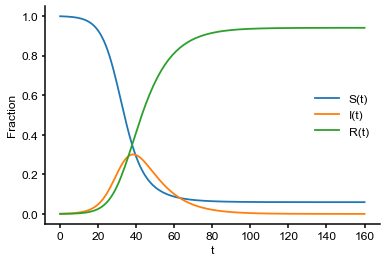

In [3]:
plt.plot(t, u.T / N)
plt.legend(["S(t)", "I(t)", "R(t)"])
plt.xlabel("t")
plt.ylabel("Fraction")
plt.show();

## Gradients

In [4]:
p = torch.tensor([0.3, 0.1], requires_grad=True)

u, t = de(u0, tspan, p)

loss = (u**2).sum()
loss.backward()

dloss = p.grad
dloss


Julia >>>

u0 = [999.0, 1.0, 0.0]
tspan = (0.0, 160.0)
p = [0.30000001192092896, 0.10000000149011612]

prob = ODEForwardSensitivityProblem(f,u0,tspan,p)

solution = solve(prob,Tsit5(),reltol=1e-08,abstol=1e-08,saveat=1.0)

u, du = extract_local_sensitivities(solution)

u, du, solution.t

<<<



tensor([ 1.5894e+08, -3.1630e+08])

## Timings

### No gradient

In [5]:
de.debug = False
p = torch.tensor([0.3, 0.1])

In [6]:
%%timeit
_ = de(u0, tspan, p)

1.63 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### With gradient

In [7]:
de.debug = False
p = torch.tensor([0.3, 0.1], requires_grad=True)

In [8]:
%%timeit
_ = de(u0, tspan, p)

2.02 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numerical checking

See: https://pytorch.org/docs/stable/autograd.html#numerical-gradient-checking
for details.

In [9]:
from torch.autograd import gradcheck

de.debug = False

def loss_fun(p):
    u, t = de(u0, tspan, p)
    return (u**2).sum()

test = gradcheck(loss_fun, p, eps=1e-4, atol=1e-4)
print(test)

True


/Users/jm/opt/anaconda3/envs/diffeqtorch/lib/python3.7/site-packages/torch/autograd/gradcheck.py:244: UserWarning: At least one of the inputs that requires gradient is not of double precision floating point. This check will likely fail if all the inputs are not of double precision floating point. 
  'At least one of the inputs that requires gradient '
